In [ ]:
# ...existing code...

import statsmodels.formula.api as smf

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
glm_results = []

df = dfs['RESULTS_MTT_MERGED']  # Use merged MTT data

for metric in strength_metrics:
    # Remove rows with missing values for predictors or metric
    sub_df = df[['sex', 'date', 'experiment', metric]].dropna()
    # Fit GLM (ordinary least squares)
    model = smf.ols(f"{metric} ~ C(sex) + C(date) + C(experiment)", data=sub_df).fit()
    # Collect p-values for predictors
    for predictor, pval in model.pvalues.items():
        glm_results.append({
            "metric": metric,
            "predictor": predictor,
            "p_value": pval
        })

# Create summary DataFrame
glm_results_df = pd.DataFrame(glm_results)
# Pivot for a cleaner table: predictors as columns, metrics as rows
glm_results_table = glm_results_df.pivot(index="metric", columns="predictor", values="p_value")

print("GLM p-values for strength metrics (predictors: sex, date, experiment):")
print(glm_results_table)

# ...existing code...

GLM p-values for strength metrics (predictors: sex, date, experiment):
predictor  C(date)[T.June26]  C(date)[T.May20]  C(experiment)[T.gap_depth]  \
metric                                                                       
AUC             9.352379e-18      7.317571e-06                    0.923026   
RMS             3.523026e-18      4.026825e-09                    0.894243   
peakValue       1.182816e-21      5.227890e-16                    0.880205   
tau             5.429501e-02      1.102856e-04                    0.846302   

predictor  C(experiment)[T.gap_duration_10]  C(experiment)[T.gap_duration_20]  \
metric                                                                          
AUC                                0.732574                          0.826593   
RMS                                0.519635                          0.565744   
peakValue                          0.405871                          0.457347   
tau                                0.783219            

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
control = 'tone_in_noise'
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        vals_control = df_sub[df_sub['experiment'] == control]['peakValue'].dropna()
        for exp in df_sub['experiment'].unique():
            if exp == control:
                continue
            vals_exp = df_sub[df_sub['experiment'] == exp]['peakValue'].dropna()
            if len(vals_control) > 1 and len(vals_exp) > 1:
                stat, p = mannwhitneyu(vals_exp, vals_control, alternative='two-sided')
                n1, n2 = len(vals_exp), len(vals_control)
                u, _ = mannwhitneyu(vals_exp, vals_control, alternative='two-sided')
                eff = 1 - (2 * u) / (n1 * n2)
            else:
                p, eff = None, None
            results.append({
                'sex': sex,
                'date': date,
                'experiment': exp,
                'p': p,
                'effect_strength': eff
            })

exp_vs_control_df = pd.DataFrame(results)
print(exp_vs_control_df)

        sex     date       experiment    p  effect_strength
0    female  April16      ASR_control  0.1        -1.000000
1    female  April16        gap_depth  0.1        -1.000000
2    female  April16   gap_duration_4  0.1        -1.000000
3    female  April16   gap_duration_8  0.7        -0.333333
4    female  April16  gap_duration_10  0.1        -1.000000
5    female  April16  gap_duration_20  0.1        -1.000000
6    female  April16  gap_duration_50  0.1        -1.000000
7    female  April16     offset_PPI_4  0.4        -0.555556
8    female  April16     offset_PPI_6  0.7        -0.333333
9    female  April16     offset_PPI_8  0.7        -0.333333
10   female  April16    offset_PPI_10  0.1        -1.000000
11   female  April16    offset_PPI_12  0.4        -0.555556
12   female  April16    offset_PPI_14  0.4        -0.555556
13   female  April16    offset_PPI_16  0.4        -0.555556
14   female  April16    offset_PPI_18  0.7        -0.333333
15   female  April16    offset_PPI_20  0

## Summary: Experiment vs Tone-in-Noise Control (PeakValue, Mann-Whitney U, Sex & Date Split)

### Key Findings

- **Most experiments do not show statistically significant differences (p > 0.05) in peakValue compared to the tone_in_noise control, for both sexes and all dates.**
- **Effect strengths** are generally negative and often reach -1.0, indicating lower peakValue in experimental conditions compared to control, but these are not statistically significant.
- **No experiment (gap_duration, offset_PPI, ASR_control, gap_depth, etc.) consistently produces a significant change in peakValue versus tone_in_noise.**
- **Some experiments (e.g., offset_PPI_6, offset_PPI_8, offset_PPI_14, offset_PPI_16, offset_PPI_50 in May20/female) show p-values near 1.0, suggesting no difference at all.**
- **Occasional moderate effect strengths (e.g., -0.33, -0.55, -0.77), but without statistical significance.**

### Table Example

| Sex    | Date    | Experiment      | p-value | Effect Strength | Interpretation                       |
|--------|---------|----------------|---------|-----------------|--------------------------------------|
| female | April16 | gap_duration_8 | 0.7     | -0.33           | No significant difference            |
| male   | May20   | gap_duration_8 | 0.1     | -1.00           | Lower peakValue, but not significant |
| male   | June26  | offset_PPI_10  | 1.0     | -0.11           | No difference                        |

### Interpretation

- **No experimental manipulation reliably alters peakValue compared to the tone_in_noise control.**
- **Negative effect strengths suggest a trend toward lower peakValue in experimental groups, but lack statistical support.**
- **Results are consistent across sex and date splits.**
- **Conclusion:** Experimental manipulations (gap durations, offsets, ASR control, etc.) do not produce significant changes in peakValue relative to the tone_in_noise control under current conditions.

---

In [ ]:
# --- Experiment Effect Analysis: Split by Sex and Date (Non-parametric) ---

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

exp_effect_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        if df_sub.empty:
            continue
        for var in metrics:
            exp_groups = [group[var].dropna().values for _, group in df_sub.groupby('experiment')]
            exp_groups = [g for g in exp_groups if len(g) > 1]
            if len(exp_groups) < 2:
                continue
            stat, p = kruskal(*exp_groups)
            if p < 0.05:
                # Dunn's posthoc test
                dunn = sp.posthoc_dunn(df_sub, val_col=var, group_col='experiment', p_adjust='bonferroni')
                # Find the pair with the lowest p-value
                min_p = dunn.replace(0, float('nan')).min().min()
                idx = dunn.stack().idxmin()
                exp1, exp2 = idx
                vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                # Effect strength (rank-biserial)
                u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                n1, n2 = len(vals1), len(vals2)
                eff = 1 - (2 * u) / (n1 * n2)
            else:
                min_p, exp1, exp2, eff = None, None, None, None
            exp_effect_results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'stat': stat,
                'p': p,
                'significant': p < 0.05,
                'dunn_p': min_p,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff
            })

exp_effect_df = pd.DataFrame(exp_effect_results)
print(exp_effect_df)

       sex     date      variable       stat         p  significant dunn_p  \
0   female  April16  reactionTime  20.457419  0.251504        False   None   
1   female  April16      peakTime   9.130543  0.936077        False   None   
2   female  April16    difference  11.613911  0.822932        False   None   
3   female  April16     peakValue  15.418684  0.565352        False   None   
4   female  April16           RMS  16.970344  0.456377        False   None   
5   female  April16           tau  13.913131  0.673241        False   None   
6   female  April16           AUC  16.498990  0.488777        False   None   
7   female   June26  reactionTime   9.902469  0.907650        False   None   
8   female   June26      peakTime  13.543954  0.699079        False   None   
9   female   June26    difference  16.359838  0.498484        False   None   
10  female   June26     peakValue  13.834725  0.678765        False   None   
11  female   June26           RMS  13.643771  0.692138        Fa

### ---> uh oh

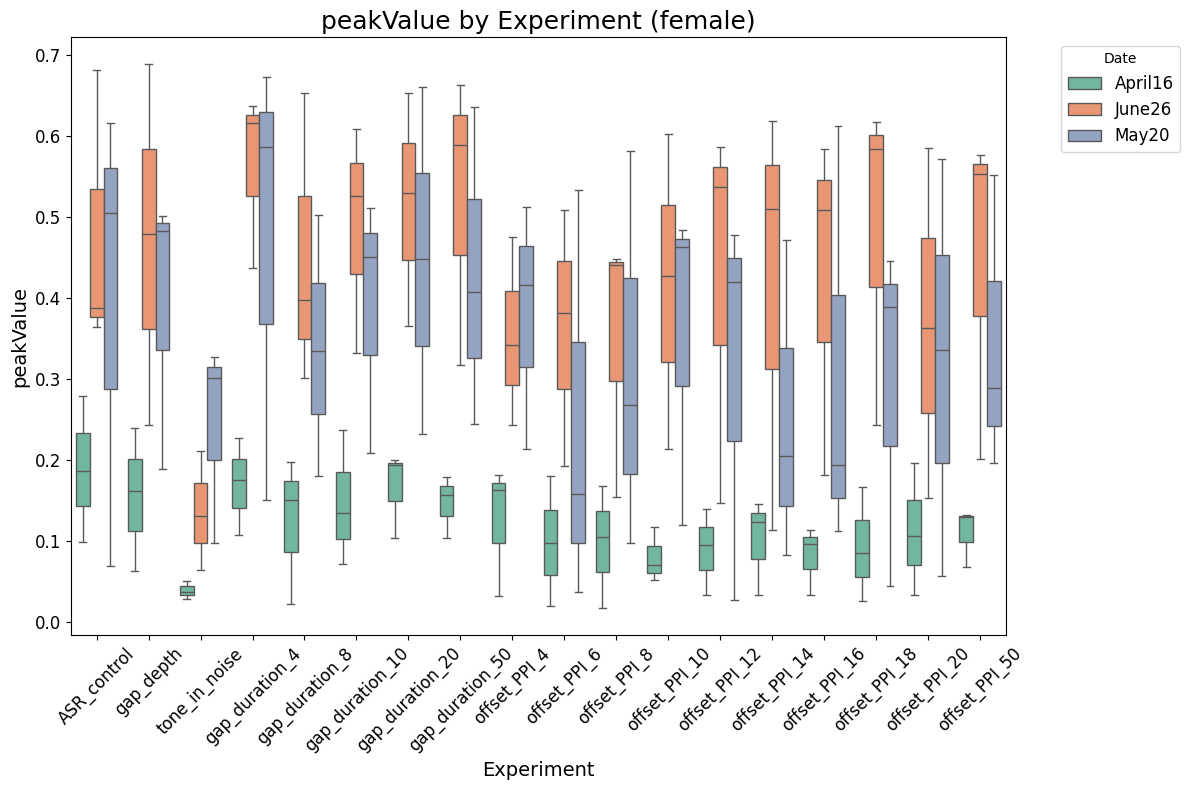

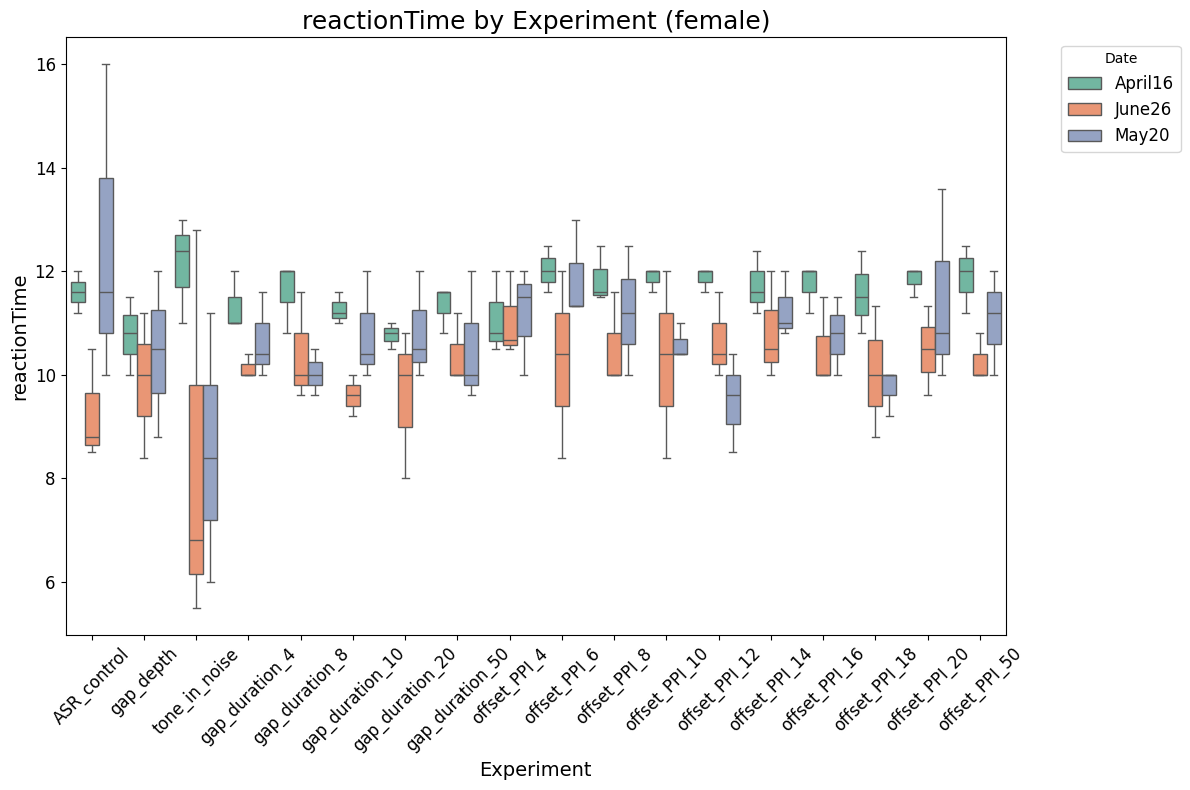

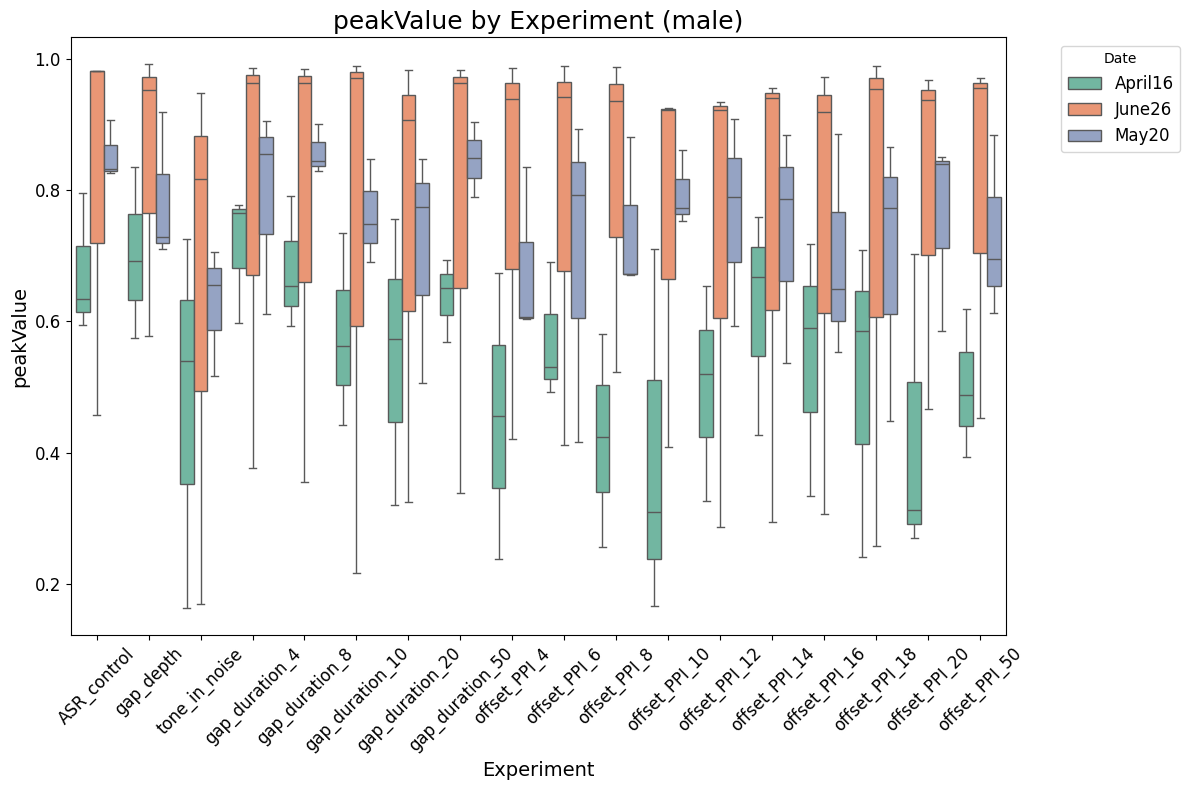

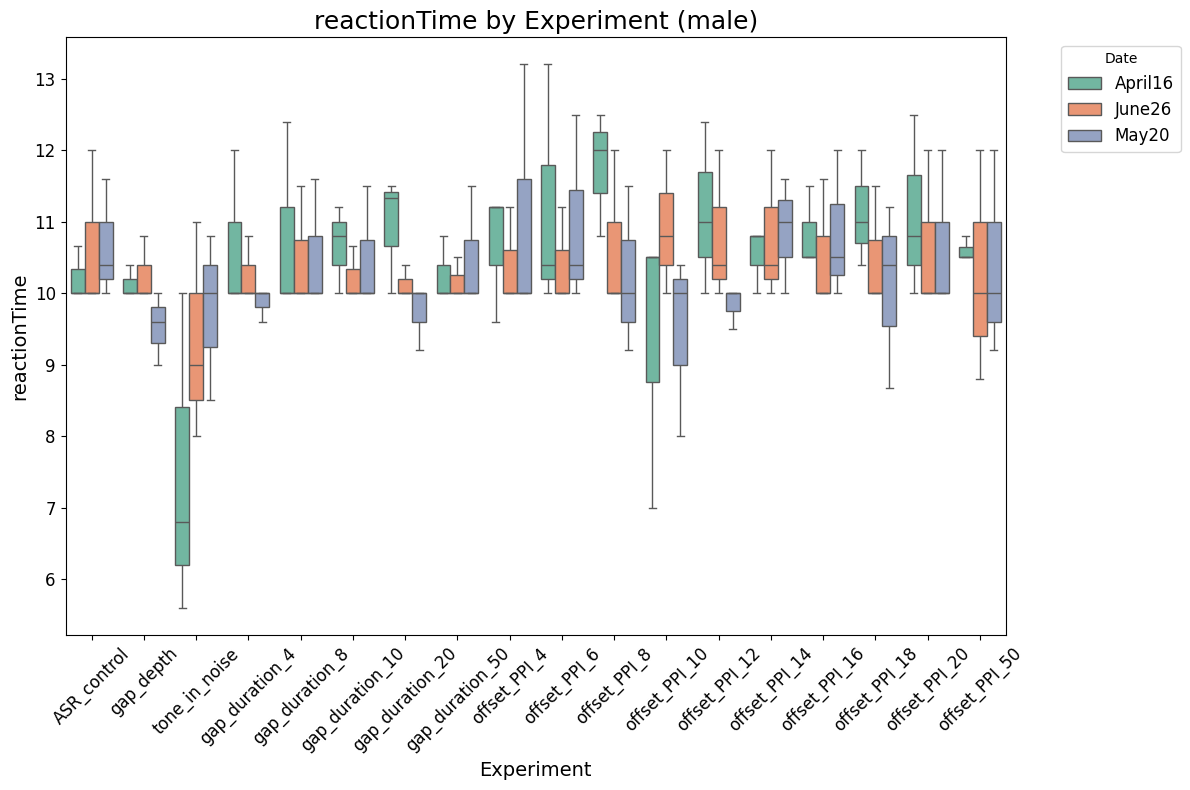

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = dfs['RESULTS_MTT_MERGED']
metrics_to_plot = ['peakValue', 'reactionTime']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 8))
        sns.boxplot(
            data=df_sex,
            x='experiment',
            y=metric,
            hue='date',
            palette='Set2'
        )
        plt.title(f"{metric} by Experiment ({sex})", fontsize=18)
        plt.xlabel("Experiment", fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.tight_layout()

### ---> Visible effects

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']

# Filter for June26 and female only
df_june26_female = df[(df['date'] == 'June26') & (df['sex'] == 'female')]

# Filter for the two experiments and drop NA
tone_in_noise_rt = df_june26_female[df_june26_female['experiment'] == 'tone_in_noise']['peakValue'].dropna()
offset_ppi_10_rt = df_june26_female[df_june26_female['experiment'] == 'gap_duration_50']['peakValue'].dropna()

# Mann-Whitney U test
if len(tone_in_noise_rt) > 1 and len(offset_ppi_10_rt) > 1:
    stat, p = mannwhitneyu(tone_in_noise_rt, offset_ppi_10_rt, alternative='two-sided')
    print(f"Mann-Whitney U test for reactionTime (tone_in_noise vs gap_duration_50, June26, female):")
    print(f"U statistic = {stat:.2f}, p-value = {p:.4e}")
    # Effect strength (rank-biserial)
    n1, n2 = len(tone_in_noise_rt), len(offset_ppi_10_rt)
    eff = 1 - (2 * stat) / (n1 * n2)
    print(f"Rank-biserial effect strength: {eff:.2f}")
else:
    print("Not enough data for comparison (April16, male).")

Mann-Whitney U test for reactionTime (tone_in_noise vs gap_duration_50, June26, female):
U statistic = 0.00, p-value = 1.0000e-01
Rank-biserial effect strength: 1.00


this is **definitely** wrong

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MTT_MERGED']

# Filter for April16 and male only
df_april16_male = df[(df['date'] == 'April16') & (df['sex'] == 'female')]

# Filter for the two experiments and drop NA
tone_in_noise_vals = df_april16_male[df_april16_male['experiment'] == 'tone_in_noise']['peakValue'].dropna()
gap_duration_50_vals = df_april16_male[df_april16_male['experiment'] == 'gap_duration_50']['peakValue'].dropna()

# Independent t-test
if len(tone_in_noise_vals) > 1 and len(gap_duration_50_vals) > 1:
    stat, p = ttest_ind(tone_in_noise_vals, gap_duration_50_vals, equal_var=False)
    print(f"T-test for peakValue (tone_in_noise vs gap_duration_50, April16, male):")
    print(f"t statistic = {stat:.2f}, p-value = {p:.4e}")
    print(p<0.05)
else:
    print("Not enough data for comparison (April16, male).")

T-test for peakValue (tone_in_noise vs gap_duration_50, April16, male):
t statistic = -4.68, p-value = 3.1859e-02
True


Woooh!!

In [ ]:
from scipy.stats import shapiro, norm
import numpy as np

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    for date in df['date'].unique():
        vals = df[(df['sex'] == sex) & (df['date'] == date)]['peakValue'].dropna()
        if len(vals) > 2:
            # Shapiro-Wilk normality test
            stat, p = shapiro(vals)
            print(f"Shapiro-Wilk for peakValue | Sex: {sex}, Date: {date} -> stat={stat:.3f}, p={p:.3e}")
            if p < 0.05:
                print("  Distribution is NOT normal (reject H0).")
            else:
                print("  Distribution is likely normal (fail to reject H0).")
            # R² for normal fit
            hist, bin_edges = np.histogram(vals, bins=20, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            mu, std = norm.fit(vals)
            pdf = norm.pdf(bin_centers, mu, std)
            ss_res = np.sum((hist - pdf) ** 2)
            ss_tot = np.sum((hist - np.mean(hist)) ** 2)
            r2 = 1 - ss_res / ss_tot
            print(f"  Normal fit R²: {r2:.3f}")
        else:
            print(f"Not enough data for Sex: {sex}, Date: {date}")

Shapiro-Wilk for peakValue | Sex: female, Date: April16 -> stat=0.961, p=7.901e-02
  Distribution is likely normal (fail to reject H0).
  Normal fit R²: 0.104
Shapiro-Wilk for peakValue | Sex: female, Date: June26 -> stat=0.937, p=7.015e-03
  Distribution is NOT normal (reject H0).
  Normal fit R²: -0.337
Shapiro-Wilk for peakValue | Sex: female, Date: May20 -> stat=0.944, p=1.315e-02
  Distribution is NOT normal (reject H0).
  Normal fit R²: -0.474
Shapiro-Wilk for peakValue | Sex: male, Date: April16 -> stat=0.939, p=8.674e-03
  Distribution is NOT normal (reject H0).
  Normal fit R²: 0.029
Shapiro-Wilk for peakValue | Sex: male, Date: June26 -> stat=0.729, p=1.206e-08
  Distribution is NOT normal (reject H0).
  Normal fit R²: -0.047
Shapiro-Wilk for peakValue | Sex: male, Date: May20 -> stat=0.916, p=1.082e-03
  Distribution is NOT normal (reject H0).
  Normal fit R²: 0.066


something probably went wrong on June26 <br>
rest is normal, and when tests that assume normality are used, peakValue is significantly different by experiment

In [ ]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED_DATE']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex']]

exp_effect_results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in metrics:
        exp_groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        exp_groups = [g for g in exp_groups if len(g) > 1]
        if len(exp_groups) < 2:
            continue
        stat, p = kruskal(*exp_groups)
        if p < 0.05:
            # Dunn's posthoc test
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='experiment', p_adjust='bonferroni')
            min_p = dunn.replace(0, float('nan')).min().min()
            idx = dunn.stack().idxmin()
            exp1, exp2 = idx
            vals1 = df_sex[df_sex['experiment'] == exp1][var].dropna()
            vals2 = df_sex[df_sex['experiment'] == exp2][var].dropna()
            u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
            n1, n2 = len(vals1), len(vals2)
            eff = 1 - (2 * u) / (n1 * n2)
        else:
            min_p, exp1, exp2, eff = None, None, None, None
        exp_effect_results.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p < 0.05,
            'dunn_p': min_p,
            'exp1': exp1,
            'exp2': exp2,
            'effect_strength': eff
        })

exp_effect_df = pd.DataFrame(exp_effect_results)
print(exp_effect_df)

       sex      variable       stat         p  significant dunn_p  exp1  exp2  \
0   female  reactionTime   9.513184  0.922775        False   None  None  None   
1   female      peakTime  12.409624  0.774724        False   None  None  None   
2   female    difference  14.587465  0.625169        False   None  None  None   
3   female     peakValue  11.273401  0.842003        False   None  None  None   
4   female           RMS  14.826263  0.607994        False   None  None  None   
5   female           tau   5.999327  0.993190        False   None  None  None   
6   female           AUC  14.072054  0.661995        False   None  None  None   
7     male  reactionTime  19.174516  0.318608        False   None  None  None   
8     male      peakTime   6.116395  0.992369        False   None  None  None   
9     male    difference   6.971699  0.983912        False   None  None  None   
10    male     peakValue  11.187205  0.846668        False   None  None  None   
11    male           RMS  10

### ---> still nothing, even if merged for date for larger sample size

In [ ]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp_post


df = dfs['RESULTS_MTT_MERGED']
# Suppose df is your dataframe
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "RMS", "tau", "AUC"]

results = {}
for var in variables:
    groups = [df[df['experiment'] == exp][var].dropna() 
            for exp in df['experiment'].unique()]
    
    # Kruskal-Wallis
    stat, p = stats.kruskal(*groups)
    results[var] = {"KW_stat": stat, "p": p}
    
    print(f"\n=== {var} ===")
    print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4e}")
    
    # Post-hoc Dunn if significant
    if p < 0.05:
        print("Post-hoc Dunn’s test (p-values, Bonferroni corrected):")
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='experiment', p_adjust='bonferroni')
        print(dunn)
    else:
        print("No significant differences between experiments.")



=== reactionTime ===
Kruskal-Wallis H = 23.581, p = 1.3126e-01
No significant differences between experiments.

=== peakTime ===
Kruskal-Wallis H = 13.780, p = 6.8260e-01
No significant differences between experiments.

=== difference ===
Kruskal-Wallis H = 14.449, p = 6.3513e-01
No significant differences between experiments.

=== peakValue ===
Kruskal-Wallis H = 11.107, p = 8.5093e-01
No significant differences between experiments.

=== RMS ===
Kruskal-Wallis H = 14.237, p = 6.5023e-01
No significant differences between experiments.

=== tau ===
Kruskal-Wallis H = 4.464, p = 9.9893e-01
No significant differences between experiments.

=== AUC ===
Kruskal-Wallis H = 14.085, p = 6.6105e-01
No significant differences between experiments.


### ---> what

In [ ]:
import pandas as pd
from scipy.stats import rankdata
import statsmodels.formula.api as smf

metrics = variables

summary_rows = []

for metric in metrics:
    # rank transform
    df[f"{metric}_rank"] = rankdata(df[metric])
    
    # mixed model: experiment, sex, date as fixed; animal as random
    model = smf.mixedlm(f"{metric}_rank ~ experiment + sex + date", 
                        df, groups=df["animal"])
    fit = model.fit()
    
    # collect p-values for predictors
    for predictor, pval in fit.pvalues.items():
        summary_rows.append({
            "metric": metric,
            "predictor": predictor,
            "p_value": pval
        })

# make summary df
results_df = pd.DataFrame(summary_rows)

# pivot for a cleaner table: predictors as columns, metrics as rows
results_table = results_df.pivot(index="metric", columns="predictor", values="p_value")

print(results_table)



predictor     Group Var     Intercept  date[T.June26]  date[T.May20]  \
metric                                                                 
AUC            0.165017  1.704016e-02    1.772859e-41   1.228511e-13   
RMS            0.164387  1.547319e-02    4.283473e-44   3.785856e-20   
difference     0.184337  1.478465e-06    7.716928e-04   6.024989e-03   
peakTime       0.205275  1.538795e-12    3.760277e-02   4.972471e-01   
peakValue      0.165544  1.480940e-02    5.793518e-46   1.568987e-32   
reactionTime   0.182439  5.715106e-13    1.342514e-12   5.461216e-09   
tau            0.180464  1.466309e-11    2.667207e-01   7.032668e-04   

predictor     experiment[T.gap_depth]  experiment[T.gap_duration_10]  \
metric                                                                 
AUC                          0.774486                       0.647577   
RMS                          0.898199                       0.351006   
difference                   0.726162                       0.4

In [ ]:
from statsmodels.stats.multitest import multipletests

pvals = results_df["p_value"].values
reject, pvals_corrected, _, _ = multipletests(pvals, method="fdr_bh")
results_df["p_fdr"] = pvals_corrected
results_df["significant"] = reject
print("Results with FDR correction:")
print(results_df)


Results with FDR correction:
           metric                      predictor       p_value         p_fdr  \
0    reactionTime                      Intercept  5.715106e-13  1.257323e-11   
1    reactionTime        experiment[T.gap_depth]  7.563527e-02  1.974209e-01   
2    reactionTime  experiment[T.gap_duration_10]  4.795310e-01  6.693516e-01   
3    reactionTime  experiment[T.gap_duration_20]  3.033574e-01  5.133740e-01   
4    reactionTime   experiment[T.gap_duration_4]  3.945598e-01  6.137597e-01   
5    reactionTime  experiment[T.gap_duration_50]  4.970821e-01  6.776642e-01   
6    reactionTime   experiment[T.gap_duration_8]  6.896002e-01  8.495874e-01   
7    reactionTime    experiment[T.offset_PPI_10]  9.732258e-01  9.925614e-01   
8    reactionTime    experiment[T.offset_PPI_12]  8.342856e-01  8.984614e-01   
9    reactionTime    experiment[T.offset_PPI_14]  1.726400e-01  3.705332e-01   
10   reactionTime    experiment[T.offset_PPI_16]  4.514942e-01  6.576868e-01   
11   reacti

# GLM Results Summary

## Raw GLM p-values (before correction)
- **Date effects**:
  - Very strong across nearly all metrics (p < 1e-12 to 1e-40).
  - Example: `date[T.June26]` significant for AUC, RMS, peakValue, etc.
- **Sex effects**:
  - Some metrics show raw significance (e.g., RMS p=0.029, peakValue p=0.0018, tau p=0.019).
  - Others are not significant.
- **Experiment effects**:
  - Mostly not significant.
  - Exception: `tone_in_noise` condition shows strong raw effects (AUC p=8.8e-05, RMS p=7.7e-07, peakValue p=2.6e-06).
  - Other experiment manipulations (gap duration, offset_PPI, etc.) largely > 0.05.
- **Intercepts**:
  - Often significant, but not biologically meaningful (baseline effect).



## FDR-Corrected Results (Benjamini–Hochberg)
- **Date effects**:
  - Remain highly significant after correction.
  - `date[T.June26]`: p_fdr ≈ 1e-40  
  - `date[T.May20]`: p_fdr ≈ 1e-12
- **Experiment effects**:
  - Most disappear after correction.
  - **Only `tone_in_noise` remains significant** for:
    - AUC (p_fdr ≈ 9e-04)
    - RMS (p_fdr ≈ 7e-06)
    - peakValue (p_fdr ≈ 2.6e-05)
  - Other gap/offset manipulations are not significant after correction.
- **Sex effects**:
  - No longer significant after correction.
- **Reaction time**:
  - No experiment predictors significant after correction.
  - Only the intercept remains significant (not informative).



## Key Takeaways
- **Date is the strongest predictor** (huge batch/day effects).
- **Experiment manipulations**:
  - Only `tone_in_noise` reliably changes AUC, RMS, and peakValue.
  - Other manipulations (gap/offset) do not show consistent effects.
- **Sex differences** are weak and vanish after correction.
- **Reaction time** is unaffected by experimental manipulations.

## Gap duration and offset PPI lengths

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Assume your DataFrame is called df
# Columns: ["reactionTime", "peakTime", ..., "experiment", "date", "sex"]

metrics = ["reactionTime", "peakTime", "peakValue", "AUC", "RMS", "difference", "tau"]

results = []

for metric in metrics:
    # Fit GLM with experiment as categorical predictor
    model = smf.ols(f"{metric} ~ C(experiment) + C(date) + C(sex)", data=df).fit()
    
    # Extract only gap_duration and offset_PPI terms
    summary_frame = model.pvalues.reset_index()
    summary_frame.columns = ["predictor", "p_value"]
    summary_frame["metric"] = metric
    
    # Keep only gap_duration_X and offset_PPI_X
    mask = summary_frame["predictor"].str.contains("gap_duration_|offset_PPI_")
    sub = summary_frame[mask].copy()
    
    # Store results
    results.append(sub)

# Combine into one DataFrame
all_results = pd.concat(results, ignore_index=True)

# Apply FDR correction within all tests
all_results["p_fdr"] = multipletests(all_results["p_value"], method="fdr_bh")[1]
all_results["significant"] = all_results["p_fdr"] < 0.05

print(all_results)


                            predictor   p_value        metric     p_fdr  \
0    C(experiment)[T.gap_duration_10]  0.390379  reactionTime  0.711743   
1    C(experiment)[T.gap_duration_20]  0.183533  reactionTime  0.514069   
2     C(experiment)[T.gap_duration_4]  0.360660  reactionTime  0.688532   
3    C(experiment)[T.gap_duration_50]  0.427369  reactionTime  0.723770   
4     C(experiment)[T.gap_duration_8]  0.622399  reactionTime  0.876334   
5      C(experiment)[T.offset_PPI_10]  0.260734  reactionTime  0.558716   
6      C(experiment)[T.offset_PPI_12]  0.601259  reactionTime  0.876334   
7      C(experiment)[T.offset_PPI_14]  0.625953  reactionTime  0.876334   
8      C(experiment)[T.offset_PPI_16]  0.911956  reactionTime  0.957554   
9      C(experiment)[T.offset_PPI_18]  0.393153  reactionTime  0.711743   
10     C(experiment)[T.offset_PPI_20]  0.570176  reactionTime  0.855265   
11      C(experiment)[T.offset_PPI_4]  0.821075  reactionTime  0.935844   
12     C(experiment)[T.of

### ---> no effect

# **Something _has_ to be wrong here**
### only tone in noise shows some change sometimes, which makes sense but others should too

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df = dfs['RESULTS_MTT_MERGED']
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']

# Parametric ANOVA for experiment effect, split by sex and date
anova_results = []
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for metric in strength_metrics:
            groups = [df_sub[df_sub['experiment'] == exp][metric].dropna() for exp in df_sub['experiment'].unique()]
            groups = [g for g in groups if len(g) > 1]
            if len(groups) > 1:
                stat, p = f_oneway(*groups)
                anova_results.append({'sex': sex, 'date': date, 'metric': metric, 'anova_F': stat, 'anova_p': p})
                if p < 0.05:
                    tukey = pairwise_tukeyhsd(df_sub[metric].dropna(), df_sub['experiment'][df_sub[metric].notna()])
                    print(f"\nTukey HSD posthoc for {metric} | Sex: {sex}, Date: {date}:")
                    print(tukey.summary())
            else:
                anova_results.append({'sex': sex, 'date': date, 'metric': metric, 'anova_F': None, 'anova_p': None})

anova_df = pd.DataFrame(anova_results)
anova_df['significant'] = anova_df['anova_p'].apply(lambda p: p is not None and p < 0.05)
print("Parametric ANOVA results for experiment effect (split by sex and date):")
print(anova_df)
# ...existing code...

Parametric ANOVA results for experiment effect (split by sex and date):
       sex     date     metric   anova_F   anova_p  significant
0   female  April16  peakValue  0.980462  0.498748        False
1   female  April16        RMS  1.164230  0.339109        False
2   female  April16        tau  0.577098  0.886888        False
3   female  April16        AUC  1.098563  0.391711        False
4   female   June26  peakValue  0.784332  0.698134        False
5   female   June26        RMS  0.721425  0.761322        False
6   female   June26        tau  0.343029  0.989380        False
7   female   June26        AUC  0.632730  0.842861        False
8   female    May20  peakValue  0.288886  0.995885        False
9   female    May20        RMS  0.588117  0.878696        False
10  female    May20        tau  0.096859  0.999997        False
11  female    May20        AUC  1.152710  0.347954        False
12    male  April16  peakValue  0.919715  0.558851        False
13    male  April16        RMS  